In [75]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedKFold, cross_val_score,train_test_split,KFold
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import scikeras
from scikeras.wrappers import KerasRegressor
import statsmodels.api as sm

## Task Description
How did the # of impressions seen by each user influence the advertising effects? \
(a) Make a graph of conversion rates as a function of the number of ads displayed. \
(b) Is there a frequency effect? Does showing more ads increase the probability of conversion?

## Import data

In [76]:
raw_data = pd.read_csv('rocketfuel_data.csv')

In [77]:
raw_data.shape

(588101, 6)

In [78]:
raw_data.head()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
0,1069124,1,0,130,1,20
1,1119715,1,0,93,2,22
2,1144181,1,0,21,2,18
3,1435133,1,0,355,2,10
4,1015700,1,0,276,5,14


In [79]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   user_id         588101 non-null  int64
 1   test            588101 non-null  int64
 2   converted       588101 non-null  int64
 3   tot_impr        588101 non-null  int64
 4   mode_impr_day   588101 non-null  int64
 5   mode_impr_hour  588101 non-null  int64
dtypes: int64(6)
memory usage: 26.9 MB


In [80]:
raw_data.describe()

,user_id,test,converted,tot_impr,mode_impr_day,mode_impr_hour
count,5.881010e+05,588101.000000,588101.000000,588101.000000,588101.000000,588101.000000
mean,1.310692e+06,0.960000,0.025239,24.820876,4.025533,14.469061
std,2.022260e+05,0.195959,0.156850,43.715181,2.004019,4.834634
min,9.000000e+05,0.000000,0.000000,1.000000,1.000000,0.000000
25%,1.143190e+06,1.000000,0.000000,4.000000,2.000000,11.000000
50%,1.313725e+06,1.000000,0.000000,13.000000,4.000000,14.000000
75%,1.484088e+06,1.000000,0.000000,27.000000,6.000000,18.000000
max,1.654483e+06,1.000000,1.000000,2065.000000,7.000000,23.000000


In [81]:
raw_data.isnull().sum()

user_id           0
test              0
converted         0
tot_impr          0
mode_impr_day     0
mode_impr_hour    0
dtype: int64

### Regulate Data Type

In [82]:
raw_data['user_id'] = raw_data['user_id'].astype(str)
raw_data['test'] = raw_data['test'].astype(int)
raw_data['converted'] = raw_data['converted'].astype(int)
raw_data['tot_impr'] = raw_data['tot_impr'].astype(int)

In [83]:
len(np.unique(raw_data.user_id))

588101

User ID is unique for each record.

### Converted Distribution

(array([573258.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  14843.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

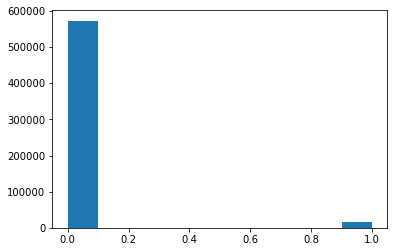

In [84]:
plt.hist(raw_data.converted)

### Total Impression Distribution

(array([5.8257e+05, 4.4990e+03, 7.4100e+02, 2.0600e+02, 5.8000e+01,
        1.3000e+01, 9.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 2.0740e+02, 4.1380e+02, 6.2020e+02, 8.2660e+02,
        1.0330e+03, 1.2394e+03, 1.4458e+03, 1.6522e+03, 1.8586e+03,
        2.0650e+03]),
 <BarContainer object of 10 artists>)

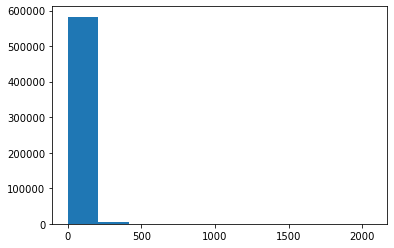

In [85]:
plt.hist(raw_data.tot_impr)

### Time Factor Distribution

(array([87073., 77479.,     0., 80908.,     0., 82982., 92608.,     0.,
        81660., 85391.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

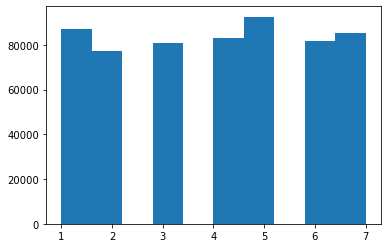

In [86]:
plt.hist(raw_data.mode_impr_day)

(array([ 15671.,   3401.,   2833.,  55036.,  85149.,  94953., 127898.,
         67311.,  59275.,  76574.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <BarContainer object of 10 artists>)

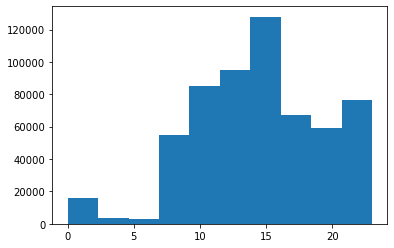

In [87]:
plt.hist(raw_data.mode_impr_hour)

In [88]:
raw_data.columns

Index(['user_id', 'test', 'converted', 'tot_impr', 'mode_impr_day',
       'mode_impr_hour'],
      dtype='object')

### Calculate Conversion rate

In [89]:
agg_data = (raw_data
            .groupby(['test', 'tot_impr', 'mode_impr_day','mode_impr_hour'])
            .agg({'converted':'sum', 'user_id':'count'})
            .rename(columns={'converted':'converted_n', 'user_id':'count_user'})
            .reset_index())

In [90]:
agg_data['converted_rate'] = agg_data['converted_n']/agg_data['count_user']

In [91]:
agg_data.head(20)

,test,tot_impr,mode_impr_day,mode_impr_hour,converted_n,count_user,converted_rate
0,0,1,1,0,0,4,0.0
1,0,1,1,1,0,2,0.0
2,0,1,1,2,0,2,0.0
3,0,1,1,7,0,7,0.0
4,0,1,1,8,0,11,0.0
5,0,1,1,9,0,23,0.0
6,0,1,1,10,0,23,0.0
7,0,1,1,11,0,26,0.0
8,0,1,1,12,0,27,0.0
9,0,1,1,13,0,33,0.0


In [92]:
agg_data.shape

(35796, 7)

(array([2.8849e+04, 1.5250e+03, 1.2980e+03, 8.7500e+02, 1.7300e+02,
        1.1580e+03, 1.2900e+02, 1.8000e+01, 5.0000e+00, 1.7660e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

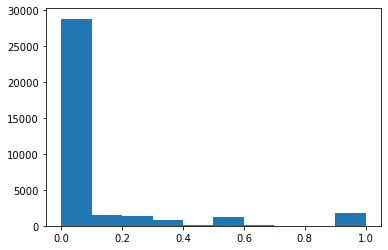

In [93]:
plt.hist(agg_data.converted_rate)

### Transform day/hour by sin/cos transformation
reference: https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/

In [94]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [95]:
agg_data["mode_impr_day_sin"] = sin_transformer(7).fit_transform(agg_data)["mode_impr_day"]
agg_data["mode_impr_day_cos"] = cos_transformer(7).fit_transform(agg_data)["mode_impr_day"]

agg_data["mode_impr_hour_sin"] = sin_transformer(24).fit_transform(agg_data)["mode_impr_hour"]
agg_data["mode_impr_hour_cos"] = cos_transformer(24).fit_transform(agg_data)["mode_impr_hour"]

In [96]:
agg_data

,test,tot_impr,mode_impr_day,mode_impr_hour,converted_n,count_user,converted_rate,mode_impr_day_sin,mode_impr_day_cos,mode_impr_hour_sin,mode_impr_hour_cos
0,0,1,1,0,0,4,0.0,0.781831,0.623490,0.000000,1.000000e+00
1,0,1,1,1,0,2,0.0,0.781831,0.623490,0.258819,9.659258e-01
2,0,1,1,2,0,2,0.0,0.781831,0.623490,0.500000,8.660254e-01
3,0,1,1,7,0,7,0.0,0.781831,0.623490,0.965926,-2.588190e-01
4,0,1,1,8,0,11,0.0,0.781831,0.623490,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...
35791,1,1491,3,7,1,1,1.0,0.433884,-0.900969,0.965926,-2.588190e-01
35792,1,1632,5,20,0,1,0.0,-0.974928,-0.222521,-0.866025,5.000000e-01
35793,1,1680,2,22,1,1,1.0,0.974928,-0.222521,-0.500000,8.660254e-01
35794,1,1778,2,18,1,1,1.0,0.974928,-0.222521,-1.000000,-1.836970e-16


In [97]:
X = agg_data[['test','tot_impr','mode_impr_day_sin','mode_impr_day_cos','mode_impr_hour_sin','mode_impr_hour_cos']]
X['tot_impr'] = (X.tot_impr-np.min(X.tot_impr))/(np.max(X.tot_impr)-np.min(X.tot_impr))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [98]:
y = agg_data['converted_rate']

### Train/test set split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Model

### Baseline: Linear Regression

In [100]:
X_train_lm_cons = sm.add_constant(X_train)

In [101]:
base_linear = sm.OLS(y_train, X_train_lm_cons)
base_linear_fitted = base_linear.fit()
print(base_linear_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:         converted_rate   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     285.1
Date:                Wed, 27 Apr 2022   Prob (F-statistic):               0.00
Time:                        07:18:24   Log-Likelihood:                 1171.7
No. Observations:               28636   AIC:                            -2329.
Df Residuals:                   28629   BIC:                            -2271.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0096      0

In [102]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model,X_train, y_train, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)
print("MSE:",np.mean(scores))

MSE: -0.05398043127878095


In [103]:
model.fit(X_train,y_train)
linear_pred = model.predict(X_test)
mean_squared_error(y_test, linear_pred)

0.052872990689787014

### AI Methods

In [104]:
def cross_validate_model(model,train_x,train_y, valid_x, valid_y):
    n_scores = cross_val_score(model, train_x,train_y, scoring='neg_mean_squared_error')
    print('Train Set MSE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))
    fitted = model.fit(train_x,train_y)
    pred = model.predict(valid_x)
    print('Test Set MSE: %.3f' % (mean_squared_error(valid_y,pred).round(5)))
    return np.mean(n_scores), np.std(n_scores), mean_squared_error(valid_y,pred)


def sklearn_fit_on_default(train_x,train_y, test_x, test_y, tf_input_layer):
    ### Machine Learning
    # Random Forest
    print("Random Forest:")
    rf_train_score,rf_train_std,rf_test_score = cross_validate_model(RandomForestRegressor(random_state=1),
                                                                     train_x,train_y, test_x, test_y)
    # Grandient Boosting
    print("Grandient Boosting:")
    gb_train_score,gb_train_std,gb_test_score = cross_validate_model(GradientBoostingRegressor(random_state=1),
                                                                     train_x,train_y, test_x, test_y)
    # LGBM
    print("LGBM:")
    lgbm_train_score,lgbm_train_std,lgbm_test_score = cross_validate_model(LGBMRegressor(random_state=1),
                                                                            train_x,train_y, test_x, test_y)
    # XGBoost
    print("XGBoost:")
    xgb_train_score,xgb_train_std,xgb_test_score = cross_validate_model(XGBRegressor(random_state=1),
                                                                        train_x,train_y, test_x, test_y)
        
    ### Deep Learning (wrap in sklearn fashion)
    # MLP
    print("sklearn MLP:")
    mlp_train_score,mlp_train_std,mlp_test_score = cross_validate_model(MLPRegressor(random_state=1, max_iter=100, hidden_layer_sizes=(20,20,20)),
                                                                        train_x,train_y, test_x, test_y)
    # Tensorflow sequential
    print("Tensorflow sequential:")
    def baseline_model():
        # create model
        model = Sequential()
        model.add(Dense(20, input_dim=tf_input_layer, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(20, activation='relu'))
        model.add(Dense(1))
        # Compile model
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mse"])
        return model
        
    tf_train_score,tf_train_std,tf_test_score = cross_validate_model(KerasRegressor(model=baseline_model, epochs=20, verbose=0),
                                                                     train_x,train_y, test_x, test_y)
        
    ### result comparison
    result_dict = {'Model':["Random Forest","Grandient Boosting","LGBM","XGBoost","sklearn MLP","Tensorflow sequential"],
                    'Train_score':[rf_train_score,gb_train_score,lgbm_train_score,xgb_train_score,mlp_train_score,tf_train_score],
                    'Train_std':[rf_train_std,gb_train_std,lgbm_train_std,xgb_train_std,mlp_train_std,tf_train_std],
                    'Test_score':[rf_test_score,gb_test_score,lgbm_test_score,xgb_test_score,mlp_test_score,tf_test_score]}
    result_pd = pd.DataFrame(result_dict)
    return result_pd

In [105]:
sklearn_fit_on_default(X_train, y_train, X_test, y_test, X_train.shape[1])

Random Forest:
Train Set MSE: -0.062 (0.001)
Test Set MSE: 0.061
Grandient Boosting:
Train Set MSE: -0.052 (0.001)
Test Set MSE: 0.051
LGBM:
Train Set MSE: -0.053 (0.001)
Test Set MSE: 0.051
XGBoost:
Train Set MSE: -0.056 (0.001)
Test Set MSE: 0.054
sklearn MLP:
Train Set MSE: -0.054 (0.001)
Test Set MSE: 0.053
Tensorflow sequential:
Train Set MSE: -0.052 (0.000)
Test Set MSE: 0.052


,Model,Train_score,Train_std,Test_score
0,Random Forest,-0.062292,0.001247,0.060856
1,Grandient Boosting,-0.051794,0.000889,0.050966
2,LGBM,-0.052544,0.000886,0.051430
3,XGBoost,-0.056287,0.000976,0.054134
4,sklearn MLP,-0.054141,0.000969,0.052618
5,Tensorflow sequential,-0.052421,0.000480,0.051694


### LGBM Fine-tuning
Reference: 
- https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
- https://www.kaggle.com/code/hamzaghanmi/xgboost-hyperparameter-tuning-using-optuna/notebook
- https://aetperf.github.io/2021/02/16/Optuna-+-XGBoost-on-a-tabular-dataset.html
- https://danilzherebtsov.medium.com/effortlessly-tune-lgbm-with-optuna-49de040d0784

In [112]:
import optuna  # pip install optuna
from optuna.integration import LightGBMPruningCallback
from lightgbm import early_stopping


def objective(trial, train_x, test_x, train_y, test_y):
    param_grid = {
        #         "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "verbosity": 0,
        "n_estimators": trial.suggest_int("n_estimators",  200, 5000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 5000, step=100),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    }
    
    model = LGBMRegressor(objective= "regression", **param_grid)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],
              callbacks=[early_stopping(50)])
    preds = model.predict(test_x)
    
    mse = mean_squared_error(test_y, preds)
    
    return mse

In [113]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, X_train, X_test, y_train, y_test)
study.optimize(func, n_trials=30, show_progress_bar=False)

[LightGBM] [Warning] lambda_l2 is set=0.21683785231335007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21683785231335007
[LightGBM] [Warning] lambda_l1 is set=0.0015345888502417367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015345888502417367
[LightGBM] [Warning] min_gain_to_split is set=5.011996828290707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.011996828290707
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] lambda_l2 is set=0.21683785231335007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21683785231335007
[LightGBM] [Warning] lambda_l1 is set=0.0015345888502417367, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015345888502417367
[LightGBM] [Warning] min_gain_to_split is set=5.011996828290707, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.011996828290707
[LightGBM] [Warning] m

In [114]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 30
Best trial: {'n_estimators': 4500, 'learning_rate': 0.016733665342759937, 'num_leaves': 1940, 'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 6.151228737404474e-06, 'lambda_l2': 1.904768284990967e-05, 'min_gain_to_split': 0.11515190368442799}


In [115]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_lambda_l1,params_lambda_l2,params_learning_rate,params_max_depth,params_min_data_in_leaf,params_min_gain_to_split,params_n_estimators,params_num_leaves,state
0,0,0.051288,2022-04-27 07:27:33.949852,2022-04-27 07:27:34.035766,0 days 00:00:00.085914,1.534589e-03,2.168379e-01,0.136992,8,500,5.011997,2100,2880,COMPLETE
1,1,0.050875,2022-04-27 07:27:34.035872,2022-04-27 07:27:34.133864,0 days 00:00:00.097992,7.140112e-01,2.717604e-08,0.133444,12,3200,0.460698,4100,1780,COMPLETE
2,2,0.051518,2022-04-27 07:27:34.133978,2022-04-27 07:27:34.231216,0 days 00:00:00.097238,5.073265e-07,4.488453e-01,0.095274,5,2200,7.383490,2500,2280,COMPLETE
3,3,0.051339,2022-04-27 07:27:34.231325,2022-04-27 07:27:34.306077,0 days 00:00:00.074752,6.186105e-05,2.549274e-03,0.178858,8,2100,4.849303,2300,300,COMPLETE
4,4,0.051052,2022-04-27 07:27:34.306182,2022-04-27 07:27:34.397782,0 days 00:00:00.091600,2.008386e+00,1.065647e-04,0.126658,9,4000,1.699599,1700,460,COMPLETE
5,5,0.051645,2022-04-27 07:27:34.397892,2022-04-27 07:27:34.484336,0 days 00:00:00.086444,1.053869e+00,5.508426e-03,0.065387,12,3100,9.198799,3500,2100,COMPLETE
6,6,0.051201,2022-04-27 07:27:34.484443,2022-04-27 07:27:34.576047,0 days 00:00:00.091604,5.418032e-08,2.180561e-07,0.234625,11,800,3.982867,1300,2760,COMPLETE
7,7,0.051739,2022-04-27 07:27:34.576155,2022-04-27 07:27:34.643493,0 days 00:00:00.067338,7.819519e-04,1.806226e-04,0.264312,9,5000,12.041370,3800,900,COMPLETE
8,8,0.051626,2022-04-27 07:27:34.643606,2022-04-27 07:27:34.724375,0 days 00:00:00.080769,7.687766e-03,2.573164e-07,0.066909,8,2300,9.130782,1800,2280,COMPLETE
9,9,0.051477,2022-04-27 07:27:34.724491,2022-04-27 07:27:34.797723,0 days 00:00:00.073232,1.016241e-02,1.085770e-04,0.170631,7,2400,7.917470,2500,1180,COMPLETE


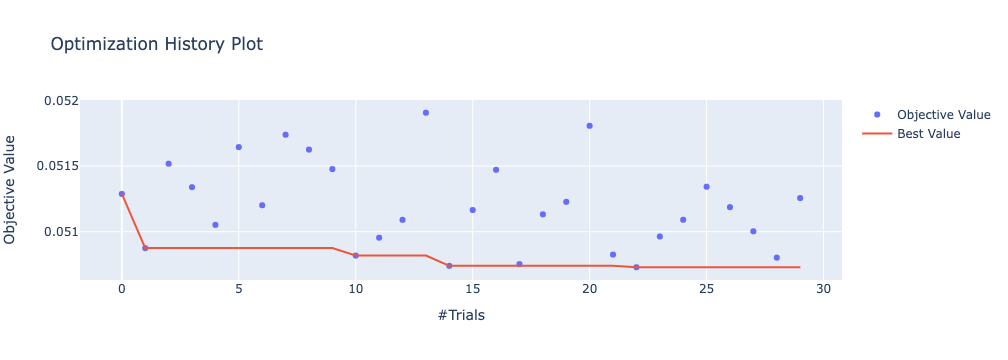

In [116]:
import plotly
optuna.visualization.plot_optimization_history(study)

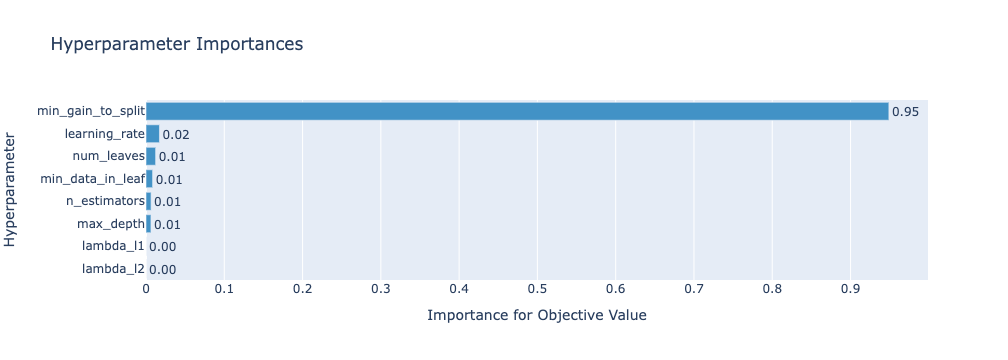

In [117]:
optuna.visualization.plot_param_importances(study)

### Best Model

In [119]:
Best_trial =  {'n_estimators': 4500, 'learning_rate': 0.016733665342759937, 'num_leaves': 1940, 
               'max_depth': 4, 'min_data_in_leaf': 200, 'lambda_l1': 6.151228737404474e-06, 
               'lambda_l2': 1.904768284990967e-05, 'min_gain_to_split': 0.11515190368442799}

In [120]:
model_opt = LGBMRegressor(**Best_trial)
model_opt.fit(X_train,y_train)
preds = model_opt.predict(X_test)
print(mean_squared_error(y_test, preds))

[LightGBM] [Warning] lambda_l1 is set=6.151228737404474e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.151228737404474e-06
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.11515190368442799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11515190368442799
[LightGBM] [Warning] lambda_l2 is set=1.904768284990967e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.904768284990967e-05
0.050760497093061914


<AxesSubplot:ylabel='Features'>

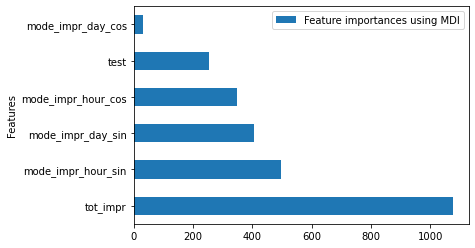

In [121]:
importances = model_opt.feature_importances_
lgbm_importances_df = (pd.DataFrame({
    "Features":X_train.columns,
    "Feature importances using MDI":importances})
                         .sort_values(by="Feature importances using MDI",ascending=False))
lgbm_importances_df.plot.barh(x="Features",y="Feature importances using MDI")

## Total impression vs conversion rate

In [122]:
model_lgbm = LGBMRegressor(**Best_trial)
model_lgbm.fit(X,y)
lgbm_pred = model_lgbm.predict(X)

[LightGBM] [Warning] lambda_l1 is set=6.151228737404474e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.151228737404474e-06
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=0.11515190368442799, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.11515190368442799
[LightGBM] [Warning] lambda_l2 is set=1.904768284990967e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.904768284990967e-05


In [123]:
agg_data['predicted_conversion_rate'] = lgbm_pred

In [124]:
grouped_data = (agg_data[['test','tot_impr','converted_rate','predicted_conversion_rate']]
                .groupby(['test','tot_impr'])
                .agg({'converted_rate':"mean",
                      'predicted_conversion_rate':"mean"})
                .reset_index())
grouped_data

,test,tot_impr,converted_rate,predicted_conversion_rate
0,0,1,0.000665,0.007974
1,0,2,0.001135,0.008081
2,0,3,0.002211,0.008270
3,0,4,0.002998,0.008255
4,0,5,0.007461,0.008166
...,...,...,...,...
1148,1,1491,1.000000,0.113590
1149,1,1632,0.000000,0.171351
1150,1,1680,1.000000,0.209894
1151,1,1778,1.000000,0.219739


<AxesSubplot:xlabel='tot_impr'>

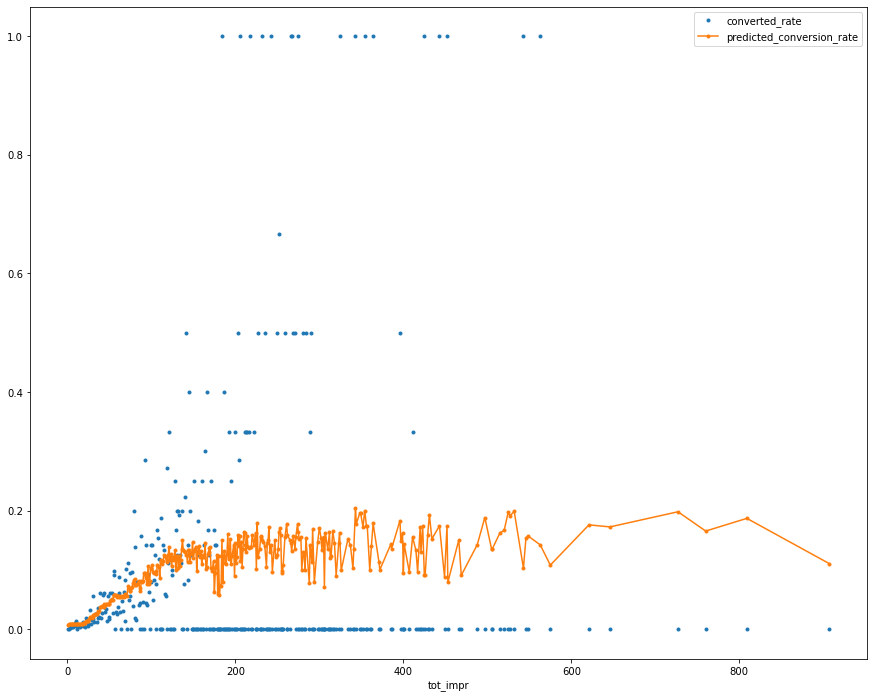

In [125]:
grouped_data[grouped_data.test==0][['tot_impr','converted_rate','predicted_conversion_rate']].set_index('tot_impr').plot(style=['.','.-'],figsize=(15,12))